In [1]:
import pickle

with open('data/sentiment_comp_qaie_pairs.pkl','rb') as f:
    pairs = pickle.loads(f.read())

In [2]:
print(len(pairs))
pairs = [p for p in pairs if p[1] not in ['无','']]
print(len(pairs))

pairs[0]

12325
12272


['智通财经APP讯，太平洋网络(00543)发布公告，将于2023年6月12日派发截至2022年12月31日止年度的末期股息每股0.1元人民币。\n---\n请从上文中抽取出所有公司/机构、对应的在本文中的情感倾向（积极、消极、中性）以及原因。\n并用这样的格式返回：\n{"ORG":..., "sentiment":..., "reason":...}',
 '{"ORG": "太平洋网络", "sentiment": "积极", "reason": "宣布派发股息每股0.1元人民币"}']

In [6]:
import json
with open('data/sentiment_comp_ie.json','w',encoding='utf8') as f:
    for p in pairs:
        line = {"q":p[0],"a":p[1]}
        f.write(json.dumps(line,ensure_ascii=False))
        f.write('\n')

In [3]:
# 打乱顺序重新排列
import json
import random
with open('data/sentiment_comp_ie_shuffled.json','w',encoding='utf8') as f:
    random_pairs = random.sample(pairs,k=len(pairs))
    for p in random_pairs:
        line = {"q":p[0],"a":p[1]}
        f.write(json.dumps(line,ensure_ascii=False))
        f.write('\n')

## baichuan-7B inference

In [1]:
# 下载百川大模型看看
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("baichuan-inc/baichuan-7B", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("baichuan-inc/baichuan-7B", device_map="auto", trust_remote_code=True).half()

/root/anaconda3/envs/gby/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 尝试从大模型中获取情感标签的概率值

In [36]:
text = "问：今天心情还真不错。这句话的情感是怎样的？答：这句话的情感是："
inputs = tokenizer.encode(text, return_tensors='pt').to('cuda:0')
# outputs = model.generate(inputs,max_new_tokens=50,do_sample=True)
# output = outputs[0][len(inputs[0]):]
# tokenizer.decode(output,skip_special_tokens=True)

In [76]:
import torch
text = "ChatGPT的推出对百度的搜索业务产生的强烈冲击，搜索引擎的作用性在降低"

prompt = f"问：{text}这句话的情感是怎样的？答：这句话的情感是："
inputs = tokenizer.encode(prompt, return_tensors='pt').to('cuda:0')

last_logits = model(inputs).logits[:,-1,:]
probs = torch.softmax(last_logits, dim=-1)

targets = {
    0: ['消极','负面','难过'],
    1: ['积极','正面','开心']
}
for key in targets:
    target_probs = []
    for w in targets[key]:
        # 取出非 bos 的第一个token（似乎无法通过 add_special_tokens=False 去掉）
        idx = tokenizer.encode(w)[1]
        current_prob = probs[0, idx].item()
        # print(w, current_prob)
        target_probs.append(current_prob)
    print(key,targets[key],'score(prob*100) =',round(sum(target_probs)*100/len(target_probs),2))
        


0 ['消极', '负面', '难过'] score(prob*100) = 0.2
1 ['积极', '正面', '开心'] score(prob*100) = 0.07


In [71]:
outputs = model.generate(inputs,max_new_tokens=50,do_sample=True)
output = outputs[0][len(inputs[0]):]
tokenizer.decode(output,skip_special_tokens=True)

'不耐烦，极其不耐烦。为什么会不耐烦呢？因为我们总是觉得对方不了解情况。1 先了解一下事情的始末吧！在说这句话的时候，对方可能会说：“事情不是这样子的呀'

In [6]:
model

BaiChuanForCausalLM(
  (model): Model(
    (embed_tokens): Embedding(64000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x DecoderLayer(
        (self_attn): Attention(
          (W_pack): Linear(in_features=4096, out_features=12288, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
        )
        (mlp): MLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=64000, bias=False)
)

In [ ]:
from peft import PeftModel
model = PeftModel.from_pretrained(model, "weights/sentiment_comp_ie_shuffled_baichuan-7B")

In [3]:
text = """ChatGPT的提出对谷嘎、万度的搜索业务产生巨大打击，传统搜索引擎的作用性降低了。
与此同时，OChat，Linguo等新兴语义搜索公司，迅速推出自己的类ChatGPT模型，并结合进自家搜索引擎，受到了很多用户的青睐。
腾势、艾里等公司表示会迅速跟进ChatGPT和AIGC的发展，并预计在年底前推出自己的大模型。
大型图片供应商视觉中国称ChatGPT对公司业务暂无影响，还在观望状态。
（本文图片来自视觉中国，上观新闻为您报道。）
更多报道：
- 亚牛逊公司关于AIGC的表态
- 巨硬公司昨日在A股上市
---
请从上文中抽取出所有公司，以及对应的在本文中的情感倾向（积极、消极、中性）以及原因。
请用这样的格式返回：
{"ORG":..., "sentiment":..., "reason":...}"""

In [5]:
from transformers import TextStreamer
streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)

inputs = tokenizer(text, return_tensors='pt')
inputs = inputs.to('cuda:0')
output = model.generate(**inputs, max_new_tokens=128,repetition_penalty=1.1, streamer=streamer)
# 模型非常自信！（类似于模型自动纠错的能力）同时幻觉十分严重，哈哈哈（当然，这只是训练了200steps）


1. {"ORG":"百度","SENTIMENT":"+20%", "REASON":"新产品发布/更新;技术突破;行业领先地位提升;市场份额扩大;营收增长;股价上涨"; }
2. {"ORG":"阿里巴巴集团","SENTIMENT":"-50%", "REASON":"竞争对手发展迅猛;业绩下滑;市值缩水;股价下跌"; }
3. {"ORG":"腾讯控股有限公司","SENTIMENT":"+40%", "REASON":"新产品发布


## ChatGLM inference

In [20]:
import torch
from transformers import AutoModel,AutoTokenizer
device=torch.device(2)

model_path = "THUDM/chatglm-6b"
# model_glm = AutoModel.from_pretrained(model_path, trust_remote_code=True).half().to(device)
model_glm = AutoModel.from_pretrained(model_path, trust_remote_code=True,device_map='auto')
tokenizer_glm = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model_glm

Loading checkpoint shards: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


In [ ]:
# load LoRA
model_glm = PeftModel.from_pretrained(model_glm, "weights/sentiment_comp_ie").half()

In [19]:
from transformers import TextStreamer
streamer = TextStreamer(tokenizer_glm,skip_prompt=True,skip_special_tokens=True)

inputs = tokenizer_glm("我们说的艾里巴巴公司，指的是", return_tensors='pt')
inputs = inputs.to('cuda:2')
output = model_glm.generate(**inputs, max_new_tokens=1024,repetition_penalty=1.1, streamer=streamer)

我不确定您所指的“艾里巴巴公司”是指哪个公司。如果您能提供更多上下文或信息,我将尽力回答您的问题。


In [17]:
print(text)

融资资金将用于完善生成式AI新引擎的构建。

创业邦获悉，自然语言技术AI服务商竹间智能宣布已完成D2轮融资，由金浦投资、金库资本、江苏文投、隽赐资本等联合投资。至今，竹间智能已累计完成7轮融资，陆续引入科沃斯、云晖资本、中银国际等股东机构。值得一提的是，竹间智能已经正式推出运用类ChatGPT技术的成熟AIGC产品，并即将开启新一轮融资。

融资资金将用于完善生成式AI新引擎的构建，把以ChatGPT为代表的大语言模型和AIGC技术全面融入竹间产品体系，结合大小模型构建双引擎驱动产品迭代和技术升级，平衡大小模型的优缺点，全面焕新产品功能和服务模式，并正式将产品同步推向海外市场，成为服务全球企业和用户的跨国NLP能力厂商。

竹间智能由前微软（亚洲）互联网工程院副院长简仁贤于2015年创办，致力于以自然语言处理、情感计算、深度学习、知识工程、文本处理等人工智能技术为基础，将AI能力惠及千行百业。

---
请从上文中抽取出所有公司，以及对应的在本文中的情感倾向（积极、消极、中性）以及原因。
请用这样的格式返回：
{"ORG":..., "sentiment":..., "reason":...}


tokenizer自动把中文括号转成英文括号了...所以你直接在输出里面可能无法直接匹配到 prompt

## ChatGLM2-6B

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("THUDM/chatglm2-6b", trust_remote_code=True)
# model = AutoModel.from_pretrained("THUDM/chatglm2-6b", trust_remote_code=True, device='cuda:0')
model = AutoModel.from_pretrained("THUDM/chatglm2-6b", trust_remote_code=True, device_map='auto')
# model = model.eval()
# model
# response, history = model.chat(tokenizer, "你好", history=[])
# print(response)

# response, history = model.chat(tokenizer, "晚上睡不着应该怎么办", history=history)
# print(response)

In [ ]:
model.hf_device_map
model.hf_device_map['transformer.output_layer'] = model.hf_device_map['transformer.embedding']
model = AutoModel.from_pretrained("THUDM/chatglm2-6b", trust_remote_code=True, device_map=model.hf_device_map)
model.hf_device_map

In [21]:
res = tokenizer('你好',return_tensors='pt')
res_glm = tokenizer_glm('你好',return_tensors='pt')

In [ ]:
labels = res['input_ids'].clone()
model(input_ids=res['input_ids'],labels=labels)

# model_glm = model_glm.half()
# labels_glm = res_glm['input_ids'].clone()
# model_glm(input_ids=res_glm['input_ids'],labels=labels_glm)

**对比一下 ChatGLM 跟 ChatGLM2 的结构差别：**

ChatGLM:
```python
ChatGLMForConditionalGeneration(
  (transformer): ChatGLMModel(
    (word_embeddings): Embedding(130528, 4096)
    (layers): ModuleList(
      (0-27): 28 x GLMBlock(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attention): SelfAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
        )
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): GLU(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)
        )
      )
    )
    (final_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4096, out_features=130528, bias=False)
```

ChatGLM2:
```python
ChatGLMForConditionalGeneration(
  (transformer): ChatGLMModel(
    (embedding): Embedding(
      (word_embeddings): Embedding(65024, 4096)   # <-- smaller vocab size
    )
    (rotary_pos_emb): RotaryEmbedding()
    (encoder): GLMTransformer(
      (layers): ModuleList(
        (0-27): 28 x GLMBlock(
          (input_layernorm): RMSNorm()   # <-- LayerNorm to RMSNorm
          (self_attention): SelfAttention(
            (query_key_value): Linear(in_features=4096, out_features=4608, bias=True)   # <-- smaller attention out_features
            (core_attention): CoreAttention(
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (dense): Linear(in_features=4096, out_features=4096, bias=False)
          )
          (post_attention_layernorm): RMSNorm()
          (mlp): MLP(                # <-- GLU to MLP
            (dense_h_to_4h): Linear(in_features=4096, out_features=27392, bias=False)
            (dense_4h_to_h): Linear(in_features=13696, out_features=4096, bias=False)
          )
        )
      )
      (final_layernorm): RMSNorm()
    )
    (output_layer): Linear(in_features=4096, out_features=65024, bias=False)    # <-- smaller out_features
  )
)
```

In [4]:
model_glm.lm_head

Linear(in_features=4096, out_features=130528, bias=False)

In [10]:
model.transformer.output_layer

Linear(in_features=4096, out_features=65024, bias=False)

In [4]:
print(model.chat(tokenizer,query=text)[0])

{"ORG": "ChatGPT", "sentiment": "消极", "reason": "ChatGPT的提出对谷嘎、万度的搜索业务产生巨大打击，传统搜索引擎的作用性降低了。"},
{"ORG": "OChat", "sentiment": "积极", "reason": "OChat，Linguo等新兴语义搜索公司，迅速推出自己的类ChatGPT模型，并结合进自家搜索引擎，受到了很多用户的青睐。"},
{"ORG": "腾势", "sentiment": "积极", "reason": "腾势、艾里等公司表示会迅速跟进ChatGPT和AIGC的发展，并预计在年底前推出自己的大模型。"},
{"ORG": "视觉中国", "sentiment": "中性", "reason": "大型图片供应商视觉中国称ChatGPT对公司业务暂无影响，还在观望状态。"},
{"ORG": "亚牛逊公司", "sentiment": "中性", "reason": "亚牛逊公司关于AIGC的表态中并未提及ChatGPT对公司业务的影响。"},
{"ORG": "巨硬公司", "sentiment": "中性", "reason": "巨硬公司昨日在A股上市与ChatGPT对公司业务的影响无关。"}


In [ ]:
from peft import PeftModel
model = PeftModel.from_pretrained(model, "weights/sentiment_comp_ie_chatglm2")

In [6]:
print(model.chat(tokenizer,text)[0])

{"ORG": "谷嘎", "sentiment": "消极", "reason": "ChatGPT的提出对其搜索业务产生巨大打击"}
{"ORG": "万度", "sentiment": "消极", "reason": "传统搜索引擎的作用性降低了"}
{"ORG": "OChat", "sentiment": "积极", "reason": "迅速推出自己的类ChatGPT模型，并结合进自家搜索引擎，受到了很多用户的青睐"}
{"ORG": "Linguo", "sentiment": "积极", "reason": "迅速推出自己的类ChatGPT模型，并结合进自家搜索引擎，受到了很多用户的青睐"}
{"ORG": "腾势", "sentiment": "积极", "reason": "会迅速跟进ChatGPT和AIGC的发展，并预计在年底前推出自己的大模型"}
{"ORG": "艾里", "sentiment": "积极", "reason": "会迅速跟进ChatGPT和AIGC的发展，并预计在年底前推出自己的大模型"}
{"ORG": "视觉中国", "sentiment": "中性", "reason": "称ChatGPT对公司业务暂无影响，还在观望状态"}


# HC3 dataset

In [ ]:
import datasets
from datasets import load_from_disk

hc3 = load_from_disk('data/hc3_chatgpt_qa_all')
hc3

In [2]:
hc3[0]

{'question': '盗贼天赋盗贼怎么加天赋?知道告诉一下下啦~~ ',
 'answer': '如果你在玩角色扮演游戏（RPG），那么你可能是在问如何在游戏中给你的盗贼角色加天赋。具体方法可能因游戏而异，但通常有以下几种方法： \n1. 在游戏开始时选择盗贼天赋：在游戏开始时，你可以选择你想要的天赋。这通常是通过选择不同的角色种族或职业来实现的。 \n2. 在游戏进程中获得天赋：在游戏进程中，你可能会获得一些与盗贼相关的天赋。这可能是通过完成任务、升级或解锁新的技能来实现的。 \n3. 使用道具或装备获得天赋：你可能会发现一些道具或装备，它们可以赋予你一些盗贼天赋。这些道具或装备通常是随机生成的，或者是你在游戏进程中获得的奖励。 \n希望这些信息对你有所帮助！'}

In [3]:
import json
with open('data/hc3_chatgpt_zh_specific_qa.json','w',encoding='utf8') as f:
    for i in range(len(hc3)):
        # line = {'q':hc3[i]['question'], 'a':hc3[i]['answer']}
        line = {'q':'问：'+hc3[i]['question'], 'a':'答：'+hc3[i]['answer']}
        line = json.dumps(line, ensure_ascii=False)
        f.write(line)
        f.write('\n')

In [ ]:

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from transformers import TextStreamer

tokenizer = AutoTokenizer.from_pretrained("baichuan-inc/baichuan-7B", trust_remote_code=True)
import torch
device = torch.device('cuda:2')
# model = AutoModelForCausalLM.from_pretrained("baichuan-inc/baichuan-7B", trust_remote_code=True).to(device)
model = AutoModelForCausalLM.from_pretrained("baichuan-inc/baichuan-7B", device_map="auto", trust_remote_code=True)



In [58]:
def chat(text):
    streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)

    inputs = tokenizer("问："+text+"答：", return_tensors='pt')
    inputs = inputs.to('cuda:2')
    output = model.generate(**inputs, max_new_tokens=128,
                            do_sample=True,
                            repetition_penalty=1.1, 
                            begin_suppress_tokens=[tokenizer.eos_token_id],
                            # streamer=streamer
                            )
    output = output[0][inputs.input_ids.shape[1]:] # 这样可以防止输出prompt部分
    return tokenizer.decode(output,skip_special_tokens=True)
    # return output
    
# chat('你怎么把断了的螺丝钉钻出来？')
# tokenizer.eos_token_id
# tokenizer.encode('  ')

In [3]:
# model = PeftModel.from_pretrained(model, "weights/rulai_plus_baichuan-7B/")
model = PeftModel.from_pretrained(model, "RLHF/weights/baichaun_rlhf_beyond_chinese_test_6step_40")

In [60]:
output = chat('哎，今天好烦啊')
print(output)

有事情想找老公商量又不好意思？


len = 2500  ~ 9G
len = 5000  ~ 40G

# InternLM

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, get_peft_model

model = AutoModelForCausalLM.from_pretrained('internlm/internlm-7b', trust_remote_code=True, device_map="auto") 
tokenizer = AutoTokenizer.from_pretrained('internlm/internlm-7b', trust_remote_code=True)

In [2]:
# 按照惯例，先观察一下模型结构
model

InternLMForCausalLM(
  (model): InternLMModel(
    (embed_tokens): Embedding(103168, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x InternLMDecoderLayer(
        (self_attn): InternLMAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (rotary_emb): InternLMRotaryEmbedding()
        )
        (mlp): InternLMMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): InternLMRMSNorm()
        (post_attention_layernorm): InternLMRMSNorm()
      )
    )
 

In [3]:
import json
from transformers import TextStreamer
def predict(text,instruction):
    streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)
    prompt = instruction + text + '\n输出：'
    inputs = tokenizer(prompt, return_tensors='pt')
    inputs = inputs.to('cuda:0')
    output = model.generate(**inputs, max_new_tokens=1024,
                            # do_sample=True,
                            # repetition_penalty=1.1, 
                            temperature=0.8,
                            top_p=0.8,
                            eos_token_id=(2, 103028),
                            # begin_suppress_tokens=[tokenizer.eos_token_id],
                            streamer=streamer
                            )
    output = output[0][inputs.input_ids.shape[1]:] # 这样可以防止输出prompt部分
    return tokenizer.decode(output,skip_special_tokens=True)

text = "首先是环境很舒服，我去过附近不少咖啡馆，像回声，咖啡王子一号店，星巴克等等，感觉他们家的环境绝对是顶尖的之一。\
星巴克适合商务人士喝杯咖啡小憩一会，回声适合安安静静的喝咖啡读书度过一个下午。这里怎么说呢，介于两者之间吧，有咖啡有西餐，\
    在这晃一天都没问题。对于我这单纯学习狗来说，音乐声音有点大，另外每个桌子都有电源，但是mac电脑的电源很不好插。\
        点了一杯香草拿铁，觉得有点甜，不过有免费的柠檬水，可以解渴。图中是芝士玉米圆饼，芝士用料很足，个人感觉不错。\
            有时间的话，在这里喝喝咖啡，读读书度过一个下午真是太舒服了。"

instruction = "给定一段文字，请你进行细粒度方面情感分析，具体包括以下这些方面：交通是否便利,距离商圈远近,是否容易寻找,排队等候时间,服务人员态度,是否容易停车,点菜/上菜速度,价格水平,性价比,折扣力度,装修情况,嘈杂情况,就餐空间,卫生情况,分量,口感,外观,推荐程度,本次消费感受,再次消费的意愿。请抽取出所有方面的情感倾向：正向:1, 中性:0, 负向:-1, 未提及:-2，用json格式返回结果。 评论如下："
output = predict(text, instruction)

# json.loads(output)

{"正向":1,"负向":0,"未提及":0,"中":0,"推荐程度":3,"性价比":3,"折扣力度":0,"装修情况":3,"嘈杂情况":0,"就餐空间":3,"卫生情况":3,"分量":3,"口感":3,"外观":3,"推荐程度":3,"再次消费的意愿":3}<eoa>


In [3]:
lora_path = '../XiaoWen/LLM-Tuning-master/weights/aspect_sentiment_jsonfy_output_10k_plus-internlm-chat-7b'
model = PeftModel.from_pretrained(model, lora_path)


json.loads(predict(text))

{"交通是否便利": "未提及", "距离商圈远近": "未提及", "是否容易寻找": "未提及", "排队等候时间": "未提及", "服务人员态度": "未提及", "是否容易停车": "未提及", "点菜/上菜速度": "未提及", "价格水平": "未提及", "性价比": "未提及", "折扣力度": "未提及", "装修情况": "正面", "嘈杂情况": "中性", "就餐空间": "正面", "卫生情况": "正面", "分量": "未提及", "口感": "中性", "外观": "未提及", "推荐程度": "未提及", "本次消费感受": "正面", "再次消费的意愿": "正面"}


{'交通是否便利': '未提及',
 '距离商圈远近': '未提及',
 '是否容易寻找': '未提及',
 '排队等候时间': '未提及',
 '服务人员态度': '未提及',
 '是否容易停车': '未提及',
 '点菜/上菜速度': '未提及',
 '价格水平': '未提及',
 '性价比': '未提及',
 '折扣力度': '未提及',
 '装修情况': '正面',
 '嘈杂情况': '中性',
 '就餐空间': '正面',
 '卫生情况': '正面',
 '分量': '未提及',
 '口感': '中性',
 '外观': '未提及',
 '推荐程度': '未提及',
 '本次消费感受': '正面',
 '再次消费的意愿': '正面'}

# !!! 重要经验
generate参数的影响巨大，应该跟 modeling_xxx.py 中默认使用的参数对应，能保证比较好的效果！

In [9]:
text = "很喜欢这家的餐，味道正宗，口感很好，是我喜欢的味道，满意值得推荐包装仔细，\
    味道很不错，小哥送的也很快，点赞！味道很惊喜，口味很赞👍相当的满足！"
output_d = json.loads(predict(text))

output_d = {k:v for k,v in output_d.items() if v != '未提及'}
output_d

{"交通是否便利": "未提及", "距离商圈远近": "未提及", "是否容易寻找": "未提及", "排队等候时间": "未提及", "服务人员态度": "未提及", "是否容易停车": "未提及", "点菜/上菜速度": "正面", "价格水平": "未提及", "性价比": "未提及", "折扣力度": "未提及", "装修情况": "未提及", "嘈杂情况": "未提及", "就餐空间": "未提及", "卫生情况": "未提及", "分量": "未提及", "口感": "正面", "外观": "未提及", "推荐程度": "未提及", "本次消费感受": "正面", "再次消费的意愿": "未提及"}


{'点菜/上菜速度': '正面', '口感': '正面', '本次消费感受': '正面'}

In [8]:
with model.disable_adapter(): # 禁用 lora
    output = predict(text)
    try:
        output_d = json.loads(output)
        output_d = {k:v for k,v in output_d.items() if v != '未提及'}
        print(output_d)
    except:
        print(output)


答案：{"pos":0,"neg":1,"neu":0,"text": "喝过最难喝的奶茶，一股水的味道，根本就喝不到奶茶味，全倒了，浪费。芋泥就一点点，珍珠就6小颗。服气了！差评，差评。"}<eoa>

答案：{"pos":0,"neg":1,"neu":0,"text": "喝过最难喝的奶茶，一股水的味道，根本就喝不到奶茶味，全倒了，浪费。芋泥就一点点，珍珠就6小颗。服气了！差评，差评。"}<eoa>


## baichuan2:

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, get_peft_model

model = AutoModelForCausalLM.from_pretrained('../DCAI-share/llm/Baichuan2-7B-Base', trust_remote_code=True, device_map="auto").half()
tokenizer = AutoTokenizer.from_pretrained('../DCAI-share/llm/Baichuan2-7B-Base', trust_remote_code=True)
# model

In [23]:
from peft import PeftModel
# lora_path = 'weights/absa_instruction-first_d1_train-1000-Baichuan2-7B-Base'
# model = PeftModel.from_pretrained(model, lora_path)

lora_path3 = 'weights/absa_lines-output_d1_train-1000-Baichuan2-7B-Base'
model.load_adapter(lora_path3, adapter_name='lines-output_d1')
model.set_adapter('lines-output_d1')

In [25]:
from transformers import TextStreamer
streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)

text = """我们又来了，自从东方广场这间分店开张以来，我们五个人已经是第三次消费，有团购这么划算的优惠，就多来一些，反正到哪里都是吃的啦！人气比刚开始时回落一点，正常现象。服务都是一如既往的好，用团购券买单还可以享用抽奖中的沙律，满意。总结之前两次得出的经验，本人认为鸡皇牛扒比杂扒好吃太多，价钱好像差不多吧。鸡扒拌天使面，可能鸡扒太肥，感觉一般。照烧鱿鱼筒是每次都点的，值得推介。长豆角也很野味，不错。这次好抽中两份奖品，要准备好下一次的钱了，再优惠些吧！\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别\n方面2：情感类别\n...\"\n输出："""
inputs = tokenizer(text, return_tensors='pt')
inputs = inputs.to('cuda:0')
output = model.generate(**inputs, max_new_tokens=128,repetition_penalty=1.1, streamer=streamer)
output = output[0][inputs.input_ids.shape[1]:] # 这样可以防止输出prompt部分
tokenizer.decode(output,skip_special_tokens=True)

食品评价：正面
饮品评价：正面
价格水平：正面
卫生情况：正面
服务人员态度：正面
停车方便程度：未提及


'食品评价：正面\n饮品评价：正面\n价格水平：正面\n卫生情况：正面\n服务人员态度：正面\n停车方便程度：未提及'

## Chinese-LLaMa

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from transformers import AutoModel, AutoModelForCausalLM, LlamaTokenizer
from peft import PeftModel, get_peft_model

model = AutoModelForCausalLM.from_pretrained('../DCAI-share/llm/chinese-alpaca-2-7b', trust_remote_code=True, device_map="auto") 
tokenizer = LlamaTokenizer.from_pretrained('../DCAI-share/llm/chinese-alpaca-2-7b', trust_remote_code=True)
# model

/root/anaconda3/envs/gby/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.8/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /root/anaconda3/envs/gby did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


In [2]:
from transformers import TextStreamer
streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)

text = """在三里屯附近搜点评看到这家店，于是过来拔草～店内环境不错，服务态度也很好，点了【安妮披萨】典型的意式薄底披萨，上面铺满培根和香肠，口味说的过去，性价比比较高 【金枪鱼意面】服务员会特意问一下意面要不要煮的软一点，因为意面本身是偏硬的，不过，还挺好吃的【炸薯条】是那种比较粗的薯条，吃起来感觉很好，喜欢！【奶油蘑菇汤】第一次吃里面都是蘑菇丁的奶油蘑菇汤，意外的很好喝～【脆皮奶酪卷】外皮酥脆，奶酪凉凉的，不是很甜腻，很适合餐后吃哦～\n这家店整体给好评的，无论是餐点还是服务、都不错！\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别，方面2：情感类别，...\"\n输出："""

# few-shot text:
# text = """Example 1:
# 在三里屯附近搜点评看到这家店，于是过来拔草～店内环境不错，服务态度也很好，点了【安妮披萨】典型的意式薄底披萨，上面铺满培根和香肠，口味说的过去，性价比比较高 【金枪鱼意面】服务员会特意问一下意面要不要煮的软一点，因为意面本身是偏硬的，不过，还挺好吃的【炸薯条】是那种比较粗的薯条，吃起来感觉很好，喜欢！【奶油蘑菇汤】第一次吃里面都是蘑菇丁的奶油蘑菇汤，意外的很好喝～【脆皮奶酪卷】外皮酥脆，奶酪凉凉的，不是很甜腻，很适合餐后吃哦～\n这家店整体给好评的，无论是餐点还是服务、都不错！\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
# 输出：食品评价：中性，饮品评价：未提及，价格水平：正面，卫生情况：未提及，服务人员态度：正面，停车方便程度：未提及。

# Example 2:
# 岛上新开的自助烤肉，价格很亲民，据说是老板试营业，找点感觉，但是对于肉食动物们，58块的价格，还是非常划算的。美团上还有团购，54.5，据说前几天刚开的时候，价格还要优惠呢！朋友说门口等位的，排队排好长呢！\n菜品质量挺好的，没有因为不高的价格而降低质量，排骨、鸡翅都很好吃。水果、熟食畅吃，碳酸饮料，啤酒畅喝，真心觉得不错！\n朋友小酌，家庭小聚，都是不错的选择。据说，小朋友去还能免单，老板还是很好的。希望以后正式开业后，生意会更好，东西更好吃。\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
# 输出：食品评价：正面，饮品评价：正面，价格水平：正面，卫生情况：未提及，服务人员态度：未提及，停车方便程度：未提及。

# Example 3:
# 口味的话只能说算是还不错的火锅 价格有点偏贵个人觉得应该在人均100左右 肉的味道还可以 给的蔬菜也比较干净 只是锅底相比较而言吃起来只能说 还不错 辣锅里面有一点太油腻了 个人不是太喜欢 整体环境很好 服务态度也是不错 自助的水果就比较少了 不过本身也不是冲着它去的 很喜欢的一点就是有那种类似于芝麻油的东西 个人不太能吃辣 吃川式火锅的时候最喜欢这个 蘸了之后又香但是还带着一点点的麻 有吃辣锅的感觉但不至于受不了 这一点还是好评的\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
# 输出："""
inputs = tokenizer(text, return_tensors='pt')
inputs = inputs.to('cuda:0')
output = model.generate(**inputs, max_new_tokens=128,repetition_penalty=1.1, streamer=streamer)


- 食品评价：正面，负面，中性，未提及
- 饮品评价：正面，负面，中性，未提及
- 价格水平：正面，负面，中性，未提及
- 卫生情况：正面，负面，中性，未提及
- 服务人员态度：正面，负面，中性，未提及
- 停车方便程度：正面，负面，中性，未提及


In [10]:
from transformers import TextStreamer
streamer = TextStreamer(tokenizer,skip_prompt=True,skip_special_tokens=True)

# text = """在三里屯附近搜点评看到这家店，于是过来拔草～店内环境不错，服务态度也很好，点了【安妮披萨】典型的意式薄底披萨，上面铺满培根和香肠，口味说的过去，性价比比较高 【金枪鱼意面】服务员会特意问一下意面要不要煮的软一点，因为意面本身是偏硬的，不过，还挺好吃的【炸薯条】是那种比较粗的薯条，吃起来感觉很好，喜欢！【奶油蘑菇汤】第一次吃里面都是蘑菇丁的奶油蘑菇汤，意外的很好喝～【脆皮奶酪卷】外皮酥脆，奶酪凉凉的，不是很甜腻，很适合餐后吃哦～\n这家店整体给好评的，无论是餐点还是服务、都不错！\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别，方面2：情感类别，...\"\n输出："""

# few-shot text:
text = """Example 1:
在三里屯附近搜点评看到这家店，于是过来拔草～店内环境不错，服务态度也很好，点了【安妮披萨】典型的意式薄底披萨，上面铺满培根和香肠，口味说的过去，性价比比较高 【金枪鱼意面】服务员会特意问一下意面要不要煮的软一点，因为意面本身是偏硬的，不过，还挺好吃的【炸薯条】是那种比较粗的薯条，吃起来感觉很好，喜欢！【奶油蘑菇汤】第一次吃里面都是蘑菇丁的奶油蘑菇汤，意外的很好喝～【脆皮奶酪卷】外皮酥脆，奶酪凉凉的，不是很甜腻，很适合餐后吃哦～\n这家店整体给好评的，无论是餐点还是服务、都不错！\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
输出：食品评价：中性，饮品评价：未提及，价格水平：正面，卫生情况：未提及，服务人员态度：正面，停车方便程度：未提及。

Example 2:
岛上新开的自助烤肉，价格很亲民，据说是老板试营业，找点感觉，但是对于肉食动物们，58块的价格，还是非常划算的。美团上还有团购，54.5，据说前几天刚开的时候，价格还要优惠呢！朋友说门口等位的，排队排好长呢！\n菜品质量挺好的，没有因为不高的价格而降低质量，排骨、鸡翅都很好吃。水果、熟食畅吃，碳酸饮料，啤酒畅喝，真心觉得不错！\n朋友小酌，家庭小聚，都是不错的选择。据说，小朋友去还能免单，老板还是很好的。希望以后正式开业后，生意会更好，东西更好吃。\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
输出：食品评价：正面，饮品评价：正面，价格水平：正面，卫生情况：未提及，服务人员态度：未提及，停车方便程度：未提及。

Example 3:
口味的话只能说算是还不错的火锅 价格有点偏贵个人觉得应该在人均100左右 肉的味道还可以 给的蔬菜也比较干净 只是锅底相比较而言吃起来只能说 还不错 辣锅里面有一点太油腻了 个人不是太喜欢 整体环境很好 服务态度也是不错 自助的水果就比较少了 不过本身也不是冲着它去的 很喜欢的一点就是有那种类似于芝麻油的东西 个人不太能吃辣 吃川式火锅的时候最喜欢这个 蘸了之后又香但是还带着一点点的麻 有吃辣锅的感觉但不至于受不了 这一点还是好评的\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
输出："""
inputs = tokenizer(text, return_tensors='pt')
inputs = inputs.to('cuda:0')
output = model.generate(**inputs, max_new_tokens=128,repetition_penalty=1.1, streamer=streamer)

食品评价：正面，饮品评价：正面，价格水平：正面，卫生情况：未提及，服务人员态度：未提及，停车方便程度：未提及。


In [38]:
def predict(prompts):
    if isinstance(prompts, str):
        prompts = [prompts]
    assert isinstance(prompts, list), 'input should be list of text'

    tokenizer.padding_side = 'left'
    input_tensors = tokenizer(prompts, max_length=1024, padding=True, truncation=True, return_tensors='pt')
    prompt_length = input_tensors.input_ids.shape[1]
    input_tensors.to('cuda:0')
    
    # 下面是 InternLM 专属 generate 参数
    # outputs = model.generate(**input_tensors, max_new_tokens=200,   # 按照指定格式，输出差不多就这么长，多了就不用输出了
    #                         repetition_penalty=1.1,
    #                         )
    outputs = model.generate(
        input_ids = input_tensors["input_ids"].to(model.device),
        attention_mask = input_tensors['attention_mask'].to(model.device),
            #eos_token_id=(2, 103028), 
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens=200,
        repetition_penalty=1.1,
        )
    # 过滤掉 prompt 部分
    real_outputs = []
    for i,output in enumerate(outputs):
        # output = output[len(inputs.input_ids[i]):]
        output = output[prompt_length:]
        real_outputs.append(output)
    results = tokenizer.batch_decode(real_outputs, skip_special_tokens=True)

    return results

text1 = """自打开业就想去尝尝，终于拔草啦。环境挺舒适的，感觉很明亮舒服～看环境以为是专门吃炸鸡的地方，看菜单才知道是韩式快餐，就是简单的拌饭、冷面之类的，也有一两个炸鸡菜和芝士火锅。有点小失望，还以为会有芝士排骨呢。他家大麦茶是用小碗盛的，挺有意思的。菜量还可以给料也挺足，口味中规中矩，价格不贵。推荐烤牛肉，牛肉火候适中洋葱是点睛之笔，甜甜的很好吃。点的时候被告知韩式辣酱无骨炸鸡要等15分钟才好，结果这菜是第一个上来的…单吃有点咸，可能是我口味淡。牛肉大酱汤里海鲜贝不少，挺舍得放的。哦对了，看旁边那桌点的海鲜乌冬面不错挺有食欲的，下次可以尝尝。写点评时才知道有买单优惠，早知道点评买单了…还能省12。\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别，方面2：情感类别，...\"\n输出："""
text2 = """刚去的时候要等位，不过只等了五分钟就有位子了，服务员看到是团购的态度也非常好，上菜也挺快的，菜的味道不错，主要是环境也好，坐着那吃很有感觉。说实话现在吃饭的地方对于这个价位来说算是做的最好的一家餐厅了！H套餐的干锅花菜(非常好吃但是量少= =)，剁椒鱼头(非常好吃，重口味)，跳跳蛙(非常好吃，重口味)，味道一级棒，排骨汤和蒸蛋就一般般了，不过毕竟是配菜也就无所谓~最后补充一句这里位置非常好，吃了就可以去不夜城水星楼玩，好方便。总之这次吃饭感觉非常好，下次还会常来，yeah~
---
阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感："方面1：情感类别，方面2：情感类别，..."
输出："""
text3 = """整个徐东这边，大概就这么一家吃印度咖喱菜的店子了。里面的装修比较简单，但是却包装的印度风格明显。菜品看上去量一般般，但是真正吃起来却非常扎实。差不多每人一个主食一个咖喱就差不多了，酒水个人认为很一般，选择也不多，也不便宜。咖喱有偏甜口语的玛莎咖喱，也有比较异域一点的酸乳酪椰香咖喱，当然也有普通的，咖喱主要是吃酱汁。用主食的米饭或者饼子沾着吃。芝士烙饼非常不错，拉丝可以很长，口感也很好。服务员态度还行，就是有的时候要叫好久。
---
阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别，方面2：情感类别，...\"\n输出："""
res = predict([text1, text2, text3])
res

['', '', '']

In [4]:
from peft import LoraModel
# lora_path = 'weights/absa_baseline_d1_train-1000-llama2'
# model = PeftModel.from_pretrained(model, lora_path)

text = """自打开业就想去尝尝，终于拔草啦。环境挺舒适的，感觉很明亮舒服～看环境以为是专门吃炸鸡的地方，看菜单才知道是韩式快餐，就是简单的拌饭、冷面之类的，也有一两个炸鸡菜和芝士火锅。有点小失望，还以为会有芝士排骨呢。他家大麦茶是用小碗盛的，挺有意思的。菜量还可以给料也挺足，口味中规中矩，价格不贵。推荐烤牛肉，牛肉火候适中洋葱是点睛之笔，甜甜的很好吃。点的时候被告知韩式辣酱无骨炸鸡要等15分钟才好，结果这菜是第一个上来的…单吃有点咸，可能是我口味淡。牛肉大酱汤里海鲜贝不少，挺舍得放的。哦对了，看旁边那桌点的海鲜乌冬面不错挺有食欲的，下次可以尝尝。写点评时才知道有买单优惠，早知道点评买单了…还能省12。\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别，方面2：情感类别，...\"\n输出："""
# text = "今天天气真不错"
inputs = tokenizer(text, return_tensors='pt')
inputs = inputs.to('cuda:0')
output = model.generate(**inputs, max_new_tokens=128,repetition_penalty=1.1, streamer=streamer)

食品评价：中性，饮品评价：未提及，价格水平：中性，卫生情况：未提及，服务人员态度：未提及，停车方便程度：未提及。


In [10]:
tokenizer.decode(output[0])
# output[0]

'<s> 今天天气真不错<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>'

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, get_peft_model

model = AutoModelForCausalLM.from_pretrained('../DCAI-share/llm/chinese-alpaca-2-7b', trust_remote_code=True, device_map="auto") 
tokenizer = AutoTokenizer.from_pretrained('../DCAI-share/llm/chinese-alpaca-2-7b', trust_remote_code=True)
model

/root/anaconda3/envs/gby/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.8/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /root/anaconda3/envs/gby did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
Loading checkpoint shards: 100%|██████████| 2/2 [01:04<00:00, 32.17s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(55296, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [2]:
# Calculating ppl
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from transformers import AutoModel, AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer
from peft import PeftModel, get_peft_model

model = AutoModelForCausalLM.from_pretrained('internlm/internlm-7b', trust_remote_code=True, device_map="auto") 
tokenizer = AutoTokenizer.from_pretrained('internlm/internlm-7b', trust_remote_code=True)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.8/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /root/anaconda3/envs/gby did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
Loading checkpoint shards: 100%|██████████| 8/8 [01:07<00:00,  8.47s/it]


In [44]:
texts = ['今年天气这阿萨德哦发in啊搜地方那仨代发不错！！！哈哈哈哈。'] * 3


encodings = tokenizer(texts, return_tensors="pt")
encodings
# encodings

{'input_ids': tensor([[    1, 29871, 32135, 33657, 30810, 31227, 33084, 31169, 32559, 30910,
           262, 32022, 34183, 32547, 31356, 52489, 30690, 30910, 33284, 30584,
         30584, 30584, 44298, 30267],
        [    1, 29871, 32135, 33657, 30810, 31227, 33084, 31169, 32559, 30910,
           262, 32022, 34183, 32547, 31356, 52489, 30690, 30910, 33284, 30584,
         30584, 30584, 44298, 30267],
        [    1, 29871, 32135, 33657, 30810, 31227, 33084, 31169, 32559, 30910,
           262, 32022, 34183, 32547, 31356, 52489, 30690, 30910, 33284, 30584,
         30584, 30584, 44298, 30267]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [47]:
outputs = model(**encodings)
outputs.logits, outputs.logits.shape

(tensor([[[-0.2758,  5.6315,  2.6591,  ...,  1.7060,  0.4519,  0.9935],
          [-1.2824, 16.4560,  5.3351,  ..., -0.4916, -3.6268, -0.8812],
          [ 1.8424,  2.5318,  8.7555,  ...,  3.1162,  3.0829,  2.4762],
          ...,
          [ 2.2414,  8.6555, 18.4061,  ...,  2.3168,  1.6600,  2.1325],
          [ 1.8043,  6.2455, 18.3456,  ...,  4.4452,  3.1189,  1.9373],
          [ 1.7926,  6.4306, 18.2170,  ...,  4.0842,  2.4521,  1.0766]],
 
         [[-0.2758,  5.6315,  2.6591,  ...,  1.7060,  0.4519,  0.9935],
          [-1.2824, 16.4560,  5.3351,  ..., -0.4916, -3.6268, -0.8812],
          [ 1.8424,  2.5318,  8.7555,  ...,  3.1162,  3.0829,  2.4762],
          ...,
          [ 2.2414,  8.6555, 18.4061,  ...,  2.3168,  1.6600,  2.1325],
          [ 1.8043,  6.2455, 18.3456,  ...,  4.4452,  3.1189,  1.9373],
          [ 1.7926,  6.4306, 18.2170,  ...,  4.0842,  2.4521,  1.0766]],
 
         [[-0.2758,  5.6315,  2.6591,  ...,  1.7060,  0.4519,  0.9935],
          [-1.2824, 16.4560,

In [49]:
res = model(**encodings, labels=encodings.input_ids)
res.loss, res.loss.shape

(tensor(7.8337, grad_fn=<ToCopyBackward0>), torch.Size([]))

In [5]:
texts = ["""上海财经大学,位于上海市,是中华人民共和国教育部直属的重点大学,位列国家“双一流”、“211工程”、“985工程优势学科创新平台"""]

encodings = tokenizer(texts[0], return_tensors="pt")
model(**encodings, labels=encodings.input_ids).loss

tensor(1.4636, grad_fn=<ToCopyBackward0>)

# Attention

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from transformers import AutoModel, AutoModelForCausalLM, LlamaTokenizer
from peft import PeftModel, get_peft_model

model = AutoModelForCausalLM.from_pretrained('../DCAI-share/llm/chinese-llama-2-7b', 
                                             trust_remote_code=True, 
                                             device_map="auto",
                                             output_attentions=True)  # <--- get attentions
tokenizer = LlamaTokenizer.from_pretrained('../DCAI-share/llm/chinese-llama-2-7b', trust_remote_code=True)

/root/anaconda3/envs/gby/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.8/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/root/anaconda3/envs/gby/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /root/anaconda3/envs/gby did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
Loading checkpoint shards: 100%|██████████| 2/2 [01:07<00:00, 33.52s/it]


In [ ]:
text1 = """冲着芝士汉堡来的，本来要等位的，结果和别人拼的大桌，环境很好，可惜服务员态度很有问题，色拉送上来了都没见有人送餐具，问了两三个服务生才要到两副刀叉，表示菜品味道还不错，服务生就大打折扣了！芝士汉堡料很足，味道很棒，色拉也是份量十足，不过凯撒色拉的面包丁看着像是搅成一坨的硬面包，焗蜗牛很香，不过有一个吃到了不明物体，不知道是香料还是啥。总体口味还不错，服务生还得多加培训才是！生意也不算最忙，但却如此怠慢客人，是在不应该！\n---\n阅读上面这段评论，观察以下这些方面：食品评价，饮品评价，价格水平，卫生情况，服务人员态度，停车方便程度。请根据评论对这些方面进行情感分析，具体有四类情感：正面、负面、中性、未提及。请用以下格式给出所有方面的情感：\"方面1：情感类别，方面2：情感类别，...\"\n输出："""
text2 = """"""
inputs = tokenizer(text1, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
outputs = model(**inputs)
A = outputs.attentions

matrix = A[layer_idx][0].sum(axis=0)
matrix = np.array(matrix.tolist())
matrix = matrix + matrix.T - np.diag(np.diag(matrix))

row = matrix.sum(axis=1).squeeze()
for i in range(len(row)):
    print(str(tokens[i])+'\t'+str(row[i]))

# Plot Example

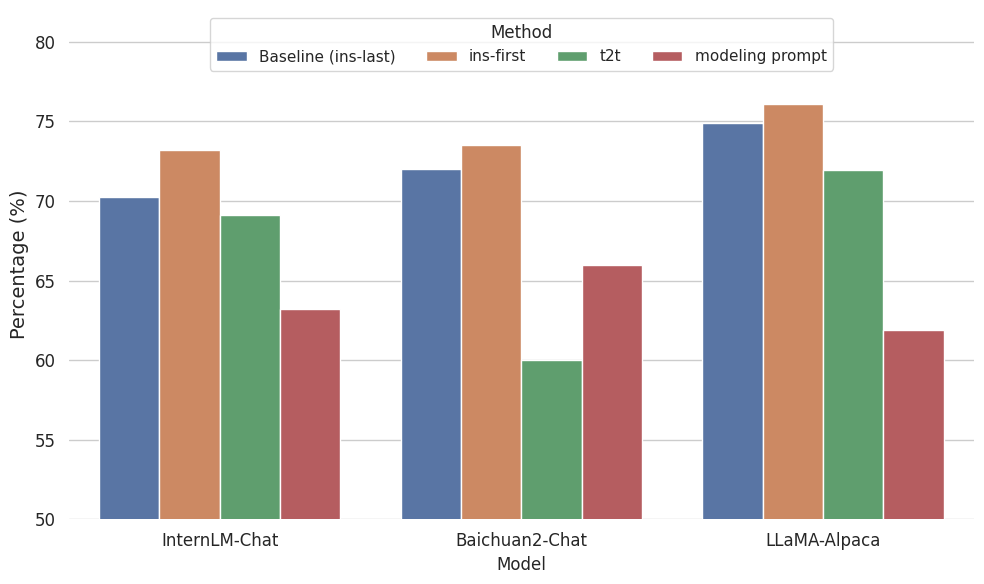

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for plotting
methods = ['Baseline (ins-last)', 'ins-first', 't2t', 'modeling prompt']
A = [70.26, 73.22, 69.13, 63.21]
B = [72.00, 73.50, 60.00, 66.00]
C = [74.87, 76.08, 71.92, 61.87]

# Data preparation
data = {
    'Method': methods * 3,
    'Percentage': A + B + C,
    'Model': ['InternLM-Chat'] * len(A) + ['Baichuan2-Chat'] * len(B) + ['LLaMA-Alpaca'] * len(C)
}
s
df = pd.DataFrame(data)

# Setting seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Percentage', hue='Method', data=df)

# Customizing the plot
# ax.set_xlabel('Group', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
# ax.set_title('Comparison of Different Methods across Groups A, B, and C', fontsize=16)
ax.set_ylim(50, 82)  # Setting y-axis limits
plt.legend(title='Method', loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(methods))  # Centered below the plot
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
sns.despine(bottom=True, left=True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()
